In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats
from sklearn import svm

In [2]:
from transformers import AutoTokenizer, AutoModel
from bert_transformer import BertTransformer

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertM

In [3]:
X_string = 'nlp_3', 'nlp_2', 'nlp_5' #tuple
Y_string = 'GDT_score'
DATASET = 'NLP_FULLSTOPS.xlsx'

In [4]:
df = pd.read_excel(io=DATASET)
df = df[df['time'] > 300]
df = df.reset_index()

bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [5]:
all_x = []

for item in X_string:

    item_processed = bert_transformer.transform(list(df[item]))
    all_x.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

all_x = tuple(all_x)
X = np.hstack(all_x)

y = df[Y_string].values
X.shape

nlp_5 added to list


(502, 2304)

In [6]:
pilot_df = pd.read_excel('NLP_PILOT.XLSX')

pilot_X = []

for item in X_string:

    item_processed = bert_transformer.transform(list(pilot_df[item]))
    pilot_X.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

pilot_X = tuple(pilot_X)
pilot_X = np.hstack(pilot_X)

pilot_Y = pilot_df[Y_string].values
pilot_X.shape

nlp_5 added to list


(95, 2304)

In [11]:
SVR_function = svm.SVR(kernel='linear', C=0.01, tol=1e-3)

In [12]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

true_data = []
results = []


for train_index, test_index in kfold.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

   
    vector_regression = SVR_function
    vector_regression.fit(X_train, y_train)
    result = vector_regression.predict(X_test)

    result = [float(item) for item in result]
    results = np.concatenate((results, result))
    true_data = np.concatenate((true_data, y_test))

    print(stats.pearsonr(result, y_test))


PearsonRResult(statistic=0.3136080737752493, pvalue=0.0250292082457495)
PearsonRResult(statistic=0.40393373854577064, pvalue=0.003287064636473323)
PearsonRResult(statistic=0.4266125711269593, pvalue=0.002005468280777035)
PearsonRResult(statistic=0.5097027432370856, pvalue=0.00015636137872154638)
PearsonRResult(statistic=0.24587419235253463, pvalue=0.08522342840522261)
PearsonRResult(statistic=0.4148036186812774, pvalue=0.002743297435864909)
PearsonRResult(statistic=0.28753083090414827, pvalue=0.04289784311507693)
PearsonRResult(statistic=0.4977030088758245, pvalue=0.00023551954218705744)
PearsonRResult(statistic=0.6382704151383402, pvalue=6.147057517268887e-07)
PearsonRResult(statistic=0.3729375666454513, pvalue=0.007645173629676758)


In [16]:
#WHOLE DATASET

results = [item if item >= 4 else 4 for item in results]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, true_data))

PearsonRResult(statistic=0.4004021594821462, pvalue=9.408717246457752e-21)


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


mae = mean_absolute_error(true_data, results)
mse = mean_squared_error(true_data, results)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')

MAE: 2.55
MSE: 12.01


In [ ]:
answers_tuples = [(y, res) for y, res in zip(y, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(item) for item in result]

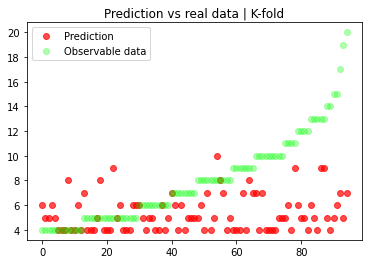

In [ ]:
plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.3], label='Observable data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | K-fold')
plt.show()

In [ ]:
# Using model to predict pilot data

vector_regression_pilot = SVR_function
vector_regression_pilot.fit(X, y)

SVR(C=0.1, kernel='linear')

In [ ]:
prediction = vector_regression_pilot.predict(pilot_X)
prediction = [float(item) for item in prediction]

results = [item if item >= 4 else 4 for item in prediction]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, pilot_Y))

PearsonRResult(statistic=0.19479671977845775, pvalue=0.05853458193529286)


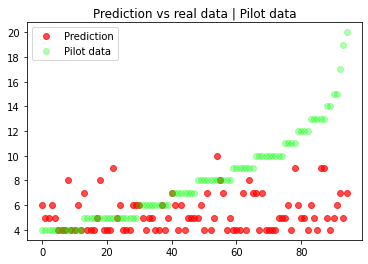

In [ ]:
answers_tuples = [(y, res) for y, res in zip(pilot_Y, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(int(item)) for item in result]

plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.3], label='Pilot data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | Pilot data')
plt.show()